In [1]:
# import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# set defaults
plt.rcParams['figure.dpi'] = 80


# Data Processing

## Load Data

In [2]:
# read data
df = pd.read_csv('../data/kddcup.data_0_1_percent.csv', index_col=0)
df.head()  # small view


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
22650,1,tcp,smtp,SF,1022,389,0,0,0,0,...,175,0.64,0.02,0.01,0.02,0.0,0.0,0.0,0.0,normal.
5765,0,tcp,http,SF,376,285,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
241826,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
292391,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
392127,0,tcp,private,S0,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.


## Subset Data

In [3]:
# filter labels
labels = df['41']  # get labels
label_counts = labels.value_counts()  # n-obs / label
mask = label_counts > df.shape[0] * 0.05  # label must encompass > 5% of the data
valid_labels = label_counts.index[mask]  # get passing labels
print(f'Passing labels = {valid_labels.tolist()}')
df = df[df['41'].isin(valid_labels)]
labels = df['41']  # redefine labels


Passing labels = ['smurf.', 'neptune.', 'normal.']


# Run Model

## Normal-Only Model

### Prepare Data

In [4]:
# split data
# - if it's an intrusion
mask_normal, mask_anomaly = labels=='normal.', labels!='normal.'  # get masks
df_normal, df_anomaly = df[mask_normal], df[mask_anomaly]  # subset data
# - set seed
random_state = 0
random.seed(random_state)
np.random.seed(0)
# - normal ml splitting
X, y = df_normal.select_dtypes(['number']), labels[mask_normal]  # last column is label
params = train_test_split(X, y, test_size=1/4, random_state=random_state, shuffle=True, stratify=y)
X_train, X_test, y_train, y_test = params
# - anomaly ml splitting
X_test_anomaly, y_test_anomaly = df_anomaly.select_dtypes(['number']), labels[mask_anomaly]


### Instantiate Model

In [5]:
# fit model - utilizes "density" splitting such that majority of data stays together
model = IsolationForest(random_state=0)
model.fit(X_train)


IsolationForest(random_state=0)

### Evaluate Model

<AxesSubplot:xlabel='Category', ylabel='AnomalyScore'>

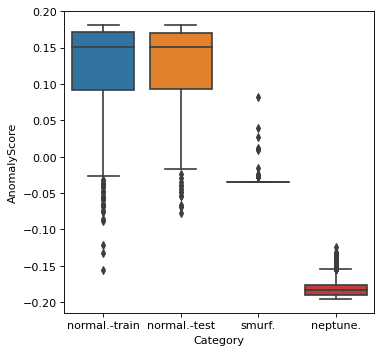

In [6]:
# plot values
# - construct dataframe
# -- normal - train
normal_train = pd.DataFrame(model.decision_function(X_train), columns=['AnomalyScore'])
normal_train['Category'] = (y_train + '-train').values
# -- normal - test
normal_test = pd.DataFrame(model.decision_function(X_test), columns=['AnomalyScore'])
normal_test['Category'] = (y_test + '-test').values
# -- intrusion
anomaly_test = pd.DataFrame(model.decision_function(X_test_anomaly), columns=['AnomalyScore'])
anomaly_test['Category'] = y_test_anomaly.values
plot_df = pd.concat([normal_train, normal_test, anomaly_test])
# - plot boxplot
fig,ax = plt.subplots(figsize=[5,5])
sns.boxplot(x='Category', y='AnomalyScore', data=plot_df, ax=ax)


Here we can see that while some data points from both the training and test dataset for what is "normal" return negative values, the overall consensus is that they are within-normal-range and "smurf" and "neptune" are intrusions. Further given the larger size of "smurf" intrusion labels it's relatively short boxplot implying strong similarity between "smurf" intrusions

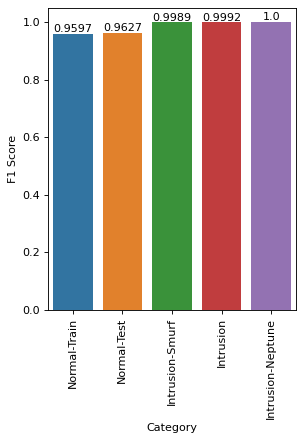

In [7]:
from sklearn.metrics import f1_score
# compute f1 scores
# - normal - train
f1_normal_train = f1_score([1]*X_train.shape[0], model.predict(X_train), pos_label=1)
# - normal - test
f1_normal_test = f1_score([1]*X_test.shape[0], model.predict(X_test), pos_label=1)
# - anomaly - smurf
mask_smurf = y_test_anomaly=='smurf.'
f1_intrusion_smurf = f1_score([-1]*sum(mask_smurf), model.predict(X_test_anomaly[mask_smurf]), pos_label=-1)
# - anomaly - neptune
mask_neptune = y_test_anomaly=='neptune.'
f1_intrusion_neptune = f1_score([-1]*sum(mask_neptune), model.predict(X_test_anomaly[mask_neptune]), pos_label=-1)
# - anomaly - all
f1_intrusion = f1_score([-1]*X_test_anomaly.shape[0], model.predict(X_test_anomaly), pos_label=-1)

# construct dataframe
f1_scores = [f1_normal_train, f1_normal_test, f1_intrusion_smurf, f1_intrusion_neptune, f1_intrusion]
categories = ['Normal-Train', 'Normal-Test', 'Intrusion-Smurf', 'Intrusion-Neptune', 'Intrusion']
plot_df = pd.DataFrame([f1_scores, categories], index=['F1 Score', 'Category']).T
plot_df = plot_df.sort_values('F1 Score')

# plot boxplot
fig,ax = plt.subplots(figsize=[4,5])
sns.barplot(x='Category', y='F1 Score', data=plot_df, ax=ax)
for x,idx in enumerate(plot_df.index):
    score = plot_df.loc[idx, 'F1 Score']
    ax.text(x, score, round(score, 4), ha='center', va='bottom')
ax.tick_params(axis='x', labelrotation=90)


Using the F1-score (weighted measurment of precision and recall) we find that the model excels in both intrusion detection and normal detection